An extension of `scratch.ipynb`. That file got too long, so I am continuing here

# Set up

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks


In [ ]:
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

In [2]:
os.chdir('..')
from src import util
os.chdir('notebooks')

In [3]:
ant_file = '../data/interim/Antimony/Simplified_Teusink_yeast.ant'
cobra_file = "../data/interim/sbml/Simplified_Teusink_yeast_cobra.xml" ## load the fba model
r = te.loada(ant_file)
data_path="../data/interim/generated_data/simplTeusink-noReg/Simplified_Teusink_yeast_3.csv"

def reload_data():
    all_data = pd.read_csv(data_path)
    return all_data

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

# all_data[fluxes]

In [14]:
import random

def assign_teams(data_path, noise_bound, n_noisy):
    all_data = pd.read_csv(data_path)
    
    all_players = set(all_data[fluxes].columns)
    team1 = set(random.sample(all_data[fluxes].columns.tolist(), n_noisy))
    team2 = all_players - team1

    # first, decide on how much noise you want to add
    noise_bound = noise_bound/100
    noise = 1 + np.random.uniform(-noise_bound, noise_bound, [n_noisy,1])

    all_data.loc[:, all_data.columns.isin(list(team1))] *= noise.squeeze()

    return team1, team2, all_data
# all_data[fluxes].head()

In [5]:
## get list of the modified fluxes
    ## team 1
## for each modified flux, adjust their bounds for FBA
# for p in all_data.rows: # for each row

def calculate_noisy_fba(team1, team2, all_data, cobra_file):
    fba_model = cobra.io.read_sbml_model(cobra_file)
    sample_flux_responses = []
    for sample in range(len(all_data)):
        for t in team1: # for each column
            rxn = t.split('_')[1]
            # set the fba bounds according to the the noise generator
            try: 
                fba_model.reactions.get_by_id(rxn).upper_bound = all_data[t][sample]
                fba_model.reactions.get_by_id(rxn).lower_bound = all_data[t][sample]
            except: 
                fba_model.reactions.get_by_id(rxn).lower_bound = all_data[t][sample]
                fba_model.reactions.get_by_id(rxn).upper_bound = all_data[t][sample]

        # find the max of team 1 fluxes and make that the upper and lower 
        # bounds for team 2 reactions. 
        dbl_bd = all_data.loc[:, all_data.columns.isin(list(team1))].max(axis=1)[sample] * 2
        for t in team2: # for each column
            rxn = t.split('_')[1]
            try: 
                fba_model.reactions.get_by_id(rxn).upper_bound = dbl_bd
                fba_model.reactions.get_by_id(rxn).lower_bound = -dbl_bd
            except: 
                fba_model.reactions.get_by_id(rxn).lower_bound = dbl_bd
                fba_model.reactions.get_by_id(rxn).upper_bound = -dbl_bd

        fba_model.reactions.vGLT.upper_bound = 5
        fba_model.reactions.vSUC.lower_bound = 0.05
        fba_model.reactions.vGLYCO.lower_bound = 0.05
        fba_model.reactions.vTreha.lower_bound = 0.05

        ## run FBA
        fba_model.objective = fba_model.reactions.vADH
        # add to sample_flux_responses
        sample_flux_responses.append(fba_model.optimize().fluxes)
        # reset the fba model
        fba_model = cobra.io.read_sbml_model(cobra_file)
    # return sample_flux_responses
    b = pd.concat(sample_flux_responses, axis=1).T.reset_index().drop(labels='index', axis=1)
    b.columns = ['v_'+i for i in b.columns]
    return b


In [6]:
# all_data = reload_data()
team1, team2, all_data = assign_teams(data_path,5)
print(team1)

{'v_vPDC', 'v_vPGK', 'v_vPYK', 'v_vG3PDH', 'v_vPGI'}


In [ ]:
fba_model = cobra.io.read_sbml_model(cobra_file)
N = cobra.util.array.create_stoichiometric_matrix(fba_model)

a = calculate_noisy_fba(team1, team2, all_data, cobra_file)

In [23]:
i = 0
n_noisy = 5
noise_bound=2
############################### 
while i < 100:
    diagnosis=[]
    fba_model = cobra.io.read_sbml_model(cobra_file)
    team1, team2, all_data = assign_teams(data_path, noise_bound, n_noisy)
    a = calculate_noisy_fba(team1, team2, all_data, cobra_file)
    for i in range(len(a)):
        if np.all(np.isclose((N@a.iloc[i]),0)):
            diagnosis.append(True)
        else:
            diagnosis.append(False)
    if all(diagnosis) == True:
        print('complete')
        c = pd.concat([all_data[enzymes+internal+external],a], axis=1)
        c.to_csv(f'Simplified_Teusink_yeast_3_fba_noisy_data_{n_noisy}-{noise_bound}.csv', index=False)
        break
    else:
        i+=1

No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model

complete


In [61]:
assert all([True, False])==False

In [57]:
for i in range(len(a)):
    if np.all(np.isclose((N@a.iloc[i]),0)):
        print('True')
    else:
        print('False')
# fba_model.create_stoichiometric_matrix()

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [50]:
pd.DataFrame(N, columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()).T

,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vPGI,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vGLYCO,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vTreha,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vPFK,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vALD,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
vGAPDH,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
vPGK,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0
vPGM,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
vENO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0


In [17]:
for i in fba_model.reactions:
    print(i.id, sol.fluxes[i.id])

vGLK 2.3267906334348716
vPGI 0.9998777790297839
vGLYCO 0.25366397864674095
vTreha 0.5366244378791734
vPFK 0.9998777790297839
vALD 1.0724641339866925
vGAPDH 1.75504553695307
vPGK 1.75504553695307
vPGM 1.6758935439568068
vENO 1.6758935439568068
vPYK 1.710721200571231
vPDC 1.7737218397160721
vSUC 0.2443905306074343
vGLT 2.3267906334348716
vADH 1.2153046480356644
vG3PDH 0.38988273102031507


In [18]:
for i in fba_model.reactions:
    print(i.id, i.upper_bound)

vGLK 2.3267906334348716
vPGI 0.9998777790297839
vGLYCO 2.3267906334348716
vTreha 0.5366244378791734
vPFK 2.3267906334348716
vALD 1.0724641339866925
vGAPDH 2.3267906334348716
vPGK 2.3267906334348716
vPGM 1.6758935439568068
vENO 2.3267906334348716
vPYK 1.710721200571231
vPDC 1.7737218397160721
vSUC 0.2443905306074343
vGLT 2.3267906334348716
vADH 1.2153046480356644
vG3PDH 0.38988273102031507


In [8]:
r.getScaledElasticityMatrix()

                GLCi,      G6P,       F6P,     F16P,      TRIO, BPG,      P3G,      P2G,       PEP,      PYR,        ACE
vGLK   [[ -0.0290019, 0.193638,        -0,       -0,        -0,  -0,       -0,       -0,        -0,       -0,         -0],
vPGI    [          0, 0.381264, -0.241208,        0,         0,   0,        0,        0,         0,        0,          0],
vGLYCO  [          0,        1,         0,        0,         0,   0,        0,        0,         0,        0,          0],
vTreha  [          0,        1,         0,        0,         0,   0,        0,        0,         0,        0,          0],
vPFK    [         -0,       -0, -0.911996, 0.987411,        -0,  -0,       -0,       -0,        -0,       -0,         -0],
vALD    [          0,        0,         0,  0.25501, -0.183274,   0,        0,        0,         0,        0,          0],
vGAPDH  [          0,        0,         0,        0,  0.342466,  -0,        0,        0,         0,        0,          0],
vPGK    [         

In [6]:
model_file = '../data/interim/Antimony/Simplified_Teusink_yeast.ant'
data_file = '../data/interim/generated_data/simplTeusink-noReg/FBA_fluxes.csv'
# MUST MAKE SURE THAT FBA SOLUTIONS LEAD TO STEADY STATE IN BMCA

In [8]:
ref_ind=0
filler_v_star=None

r = te.loada(model_file)
r.conservedMoietyAnalysis = True

if isinstance(data_file, str):
    df = pd.read_csv(data_file)
elif isinstance(data_file, pd.DataFrame):
    df = data_file

# in case of omitted data
available_fl_sp = [i for i in r.getFloatingSpeciesIds() if i in df.columns]
available_bd_sp = [i for i in r.getBoundarySpeciesIds() if i in df.columns]

enzymes = ['e_' + i for i in r.getReactionIds()]
available_enz = [i for i in enzymes if i in df.columns]

fluxes = ['v_' + i for i in r.getReactionIds()]
available_fluxes = [i for i in fluxes if i in df.columns]

# clean the data
data = df.drop(df[df[available_fl_sp].lt(0).any(axis=1)].index)

# sorting the data

e = data[available_enz]
x = data[available_fl_sp]
y = data[available_bd_sp]
v = data[available_fluxes]

# normalizing the data
#  'ref' should be the first row of data
# ref_ind = data.idxmax()[desired_product]   
e_star = e.iloc[ref_ind].values
x_star = x.iloc[ref_ind].values
y_star = y.iloc[ref_ind].values
v_star = v.iloc[ref_ind].values



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 0 is different from 16)

In [ ]:
e_star[e_star == 0] = 1e-6
x_star[x_star == 0] = 1e-6
y_star[y_star == 0] = 1e-6
v_star[v_star == 0] = 1e-9

# Normalize to reference values (and drop trivial measurement)
en = e.divide(e_star)
xn = x.divide(x_star)
yn = y.divide(y_star)
vn = v.divide(v_star)

#en.drop(en.index[ref_ind], inplace=True)
#xn.drop(xn.index[ref_ind], inplace=True)
#yn.drop(yn.index[ref_ind], inplace=True)
#vn.drop(vn.index[ref_ind], inplace=True)

N = r.getFullStoichiometryMatrix()

# Correct negative flux values at the reference state
N[:, v_star < 0] = -1 * N[:, v_star < 0]
v_star = np.abs(v_star)

assert np.all(np.isclose(np.matmul(N, v_star), 0)), "data does not describe steady state"

In [10]:
N = r.getFullStoichiometryMatrix()

# Correct negative flux values at the reference state
N[:, v_star < 0] = -1 * N[:, v_star < 0]
v_star = np.abs(v_star)


In [12]:
N.shape

(11, 16)

In [13]:
v_star.shape

(0,)

## Helper functions

In [2]:
def plot_elasticity_heatmap(rr_obj): 
    fig, ax = plt.subplots()
    im = ax.imshow(rr_obj.getScaledElasticityMatrix(), cmap='hot', interpolation='nearest')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(rr_obj.getFloatingSpeciesIds())), labels=rr_obj.getFloatingSpeciesIds())
    ax.set_yticks(np.arange(len(rr_obj.getReactionIds())), labels=rr_obj.getReactionIds())
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(rr_obj.getReactionIds())):
        for j in range(len(rr_obj.getReactionIds())):
            text = ax.text(j, i, round(rr_obj.getScaledFluxControlCoefficientMatrix()[i, j],2),
                        ha="center", va="center", color="w", size=5)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax)           
    plt.show()


def plot_FCC_heatmap(rr_obj): 
    fig, ax = plt.subplots()
    im = ax.imshow(rr_obj.getScaledFluxControlCoefficientMatrix(), cmap='hot', interpolation='nearest')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(rr_obj.getReactionIds())), labels=rr_obj.getReactionIds())
    ax.set_yticks(np.arange(len(rr_obj.getReactionIds())), labels=rr_obj.getReactionIds())

    # Loop over data dimensions and create text annotations.
    for i in range(len(rr_obj.getReactionIds())):
        for j in range(len(rr_obj.getReactionIds())):
            text = ax.text(j, i, round(rr_obj.getScaledFluxControlCoefficientMatrix()[i, j],2),
                        ha="center", va="center", color="w", size=5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()


## Scratch space

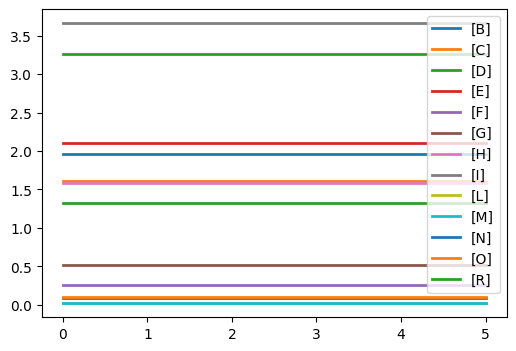

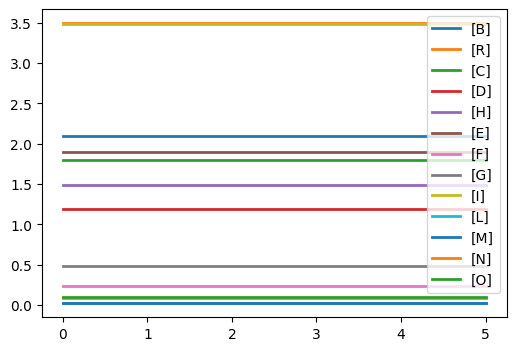

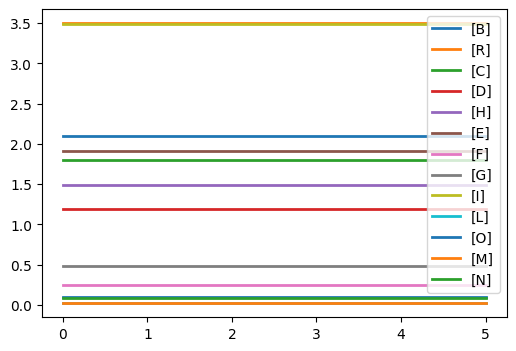

In [3]:
ex = te.loada('../data/interim/antimony/JSexample22.ant')
ex1 = te.loada('../data/interim/antimony/JSexample22_reg1.ant')
ex2 = te.loada('../data/interim/antimony/JSexample22_reg2.ant')

ex.steadyState()
ex.simulate()
ex.plot()
ex1.steadyState()
ex1.simulate()
ex1.plot()
ex2.steadyState()
ex2.simulate()
ex2.plot()

In [4]:
ex1.kH_Ref = 0.5
pd.DataFrame(ex1.getScaledElasticityMatrix()['v5'], index=ex1.getFloatingSpeciesIds()).T

,B,R,C,D,H,E,F,G,I,L,M,N,O
0,0.0,0.0,0.878918,-0.638642,-0.179943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ex1.kH_Ref = 0.05
pd.DataFrame(ex1.getScaledElasticityMatrix()['v5'], index=ex1.getFloatingSpeciesIds()).T

,B,R,C,D,H,E,F,G,I,L,M,N,O
0,0.0,0.0,1.173428,-0.463456,-0.686939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# original, no changes
pd.DataFrame(ex2.getScaledElasticityMatrix()['v5'], index=ex2.getFloatingSpeciesIds()).T

,B,R,C,D,H,E,F,G,I,L,O,M,N
0,0.0,0.0,0.879317,-0.639183,-0.179893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# original, no changes
pd.DataFrame(ex2.getScaledElasticityMatrix()['v15'], index=ex2.getFloatingSpeciesIds()).T

,B,R,C,D,H,E,F,G,I,L,O,M,N
0,0.0,0.0,0.0,0.0,0.0,0.0,0.714601,0.0,0.0,-0.326304,-0.064708,0.0,0.0


In [8]:
ex2.kH_Ref = 0.05
pd.DataFrame(ex2.getScaledElasticityMatrix()['v5'], index=ex2.getFloatingSpeciesIds()).T

,B,R,C,D,H,E,F,G,I,L,O,M,N
0,0.0,0.0,1.17377,-0.463902,-0.686867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
ex2.resetAll()
ex2.kH_Ref = 0.05
ex2.kO_Ref = 0.05
pd.DataFrame(ex2.getScaledElasticityMatrix()['v15'], index=ex2.getFloatingSpeciesIds()).T

,B,R,C,D,H,E,F,G,I,L,O,M,N
0,0.0,0.0,0.0,0.0,0.0,0.0,0.706806,0.0,0.0,-0.368978,-0.245018,0.0,0.0


## heatmaps

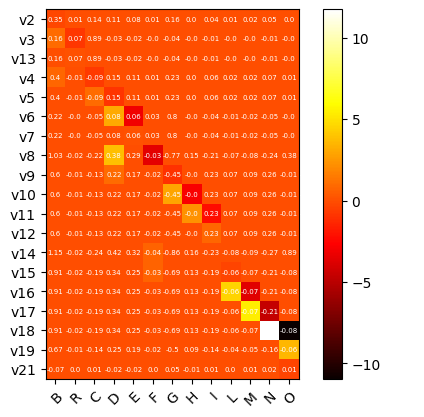

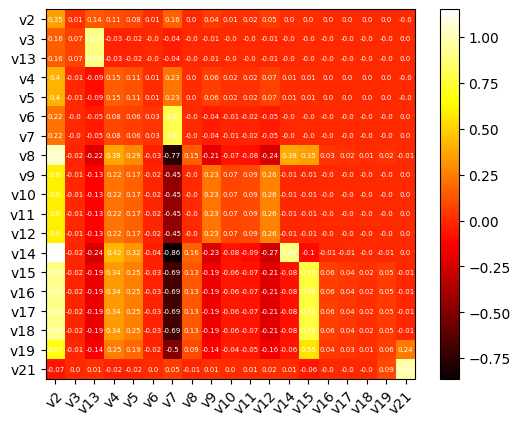

In [46]:
plot_elasticity_heatmap(ex)
plot_FCC_heatmap(ex)

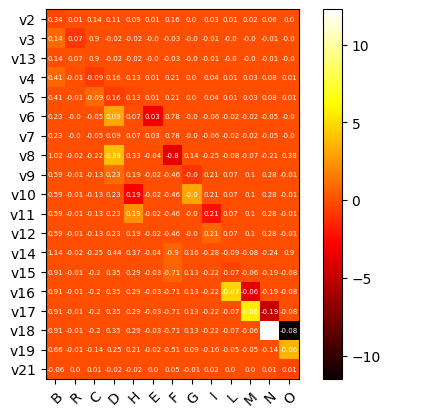

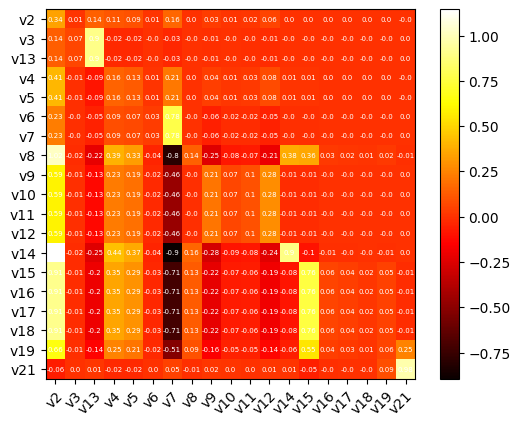

In [47]:
plot_elasticity_heatmap(ex1)
plot_FCC_heatmap(ex1)

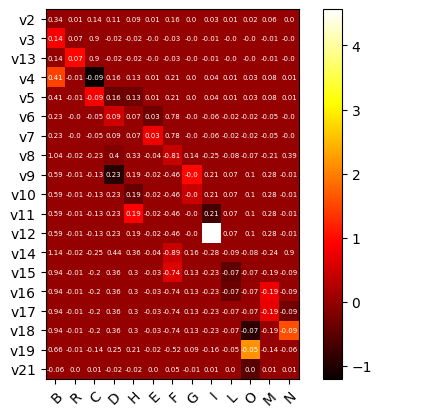

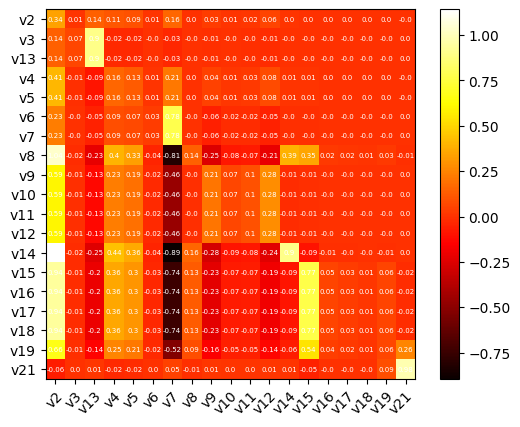

In [50]:
ex2 = te.loada('../data/JSexample22_reg2.ant')
plot_elasticity_heatmap(ex2)
plot_FCC_heatmap(ex2)

## other code

In [43]:
ex1.getScaledFluxControlCoefficientMatrix()

               v2,          v3,        v13,         v4,         v5,          v6,         v7,           v8,         v9,         v10,         v11,        v12,          v14,          v15,          v16,          v17,          v18,          v19,          v21
v2  [[    0.35681,  0.00987794,   0.141535,   0.126145,  0.0658425,  0.00748069,   0.160352,   0.00158767,  0.0282388,  0.00892925,    0.021706,  0.0626171,   0.00417636,   0.00395221,  0.000297828,  0.000198868,  7.75695e-05,  0.000240251, -6.46192e-05],
v3   [   0.129441,   0.0632506,   0.906278, -0.0253864, -0.0132507, -0.00150547, -0.0322704, -0.000319516,  -0.005683, -0.00179699, -0.00436828, -0.0126016, -0.000840484, -0.000795374, -5.99373e-05, -4.00218e-05, -1.56107e-05, -4.83501e-05,  1.30045e-05],
v13  [   0.129441,   0.0632506,   0.906278, -0.0253864, -0.0132507, -0.00150547, -0.0322704, -0.000319516,  -0.005683, -0.00179699, -0.00436828, -0.0126016, -0.000840484, -0.000795374, -5.99373e-05, -4.00218e-05, -1.56107e-05, -4.8350

In [44]:
ex2.getScaledFluxControlCoefficientMatrix()

               v2,          v3,       v13,         v4,         v5,          v6,         v7,           v8,          v9,         v10,         v11,        v12,          v14,          v15,          v16,          v17,          v18,          v19,          v21
v2  [[   0.357758,  0.00980872,  0.141813,   0.127265,  0.0682552,  0.00743974,   0.157992,   0.00147044,   0.0277353,  0.00874638,   0.0213621,  0.0615719,   0.00412692,   0.00339832,  0.000255492,  0.000170557,  0.000254451,  0.000789746,  -0.00021362],
v3   [   0.127249,   0.0627487,   0.90721, -0.0252154, -0.0135236, -0.00147405, -0.0313033, -0.000291341, -0.00549526, -0.00173294, -0.00423253, -0.0121994, -0.000817676, -0.000673316, -5.06212e-05, -3.37928e-05, -5.04149e-05, -0.000156474,  4.23251e-05],
v13  [   0.127249,   0.0627487,   0.90721, -0.0252154, -0.0135236, -0.00147405, -0.0313033, -0.000291341, -0.00549526, -0.00173294, -0.00423253, -0.0121994, -0.000817676, -0.000673316, -5.06212e-05, -3.37928e-05, -5.04149e-05, -0.0001

In [8]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks')

In [9]:
og_ant = '../data/interim/Antimony/BIOMD0000000064_e.ant'
og = te.loada(og_ant)
og.steadyState()

r_ant ='../data/interim/Antimony/Simplified_Teusink_yeast.ant'
r1_ant = '../data/interim/Antimony/Simplified_Teusink_reg1.ant' 
r2_ant = '../data/interim/Antimony/Simplified_Teusink_reg2.ant' 

r = te.loada(r_ant)
r1 = te.loada(r1_ant)
r2 = te.loada(r2_ant)

r.conservedMoietyAnalysis = True
r.steadyState()
r1.steadyState()
r2.steadyState()

1.025079205553247e-15

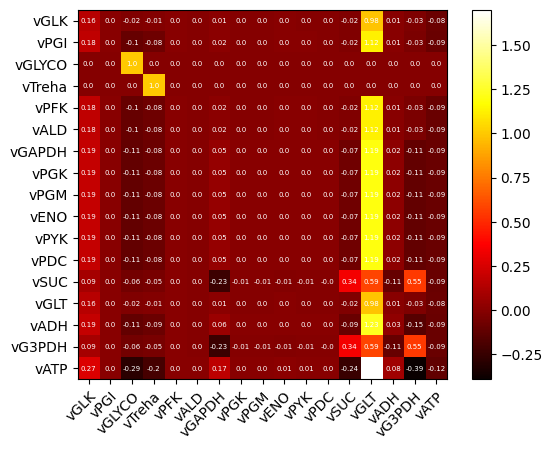

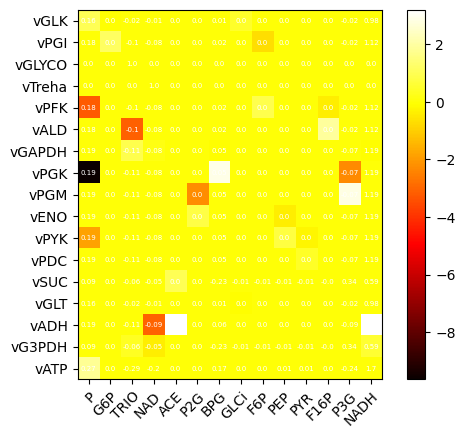

In [10]:
plot_FCC_heatmap(og)
plot_elasticity_heatmap(og)

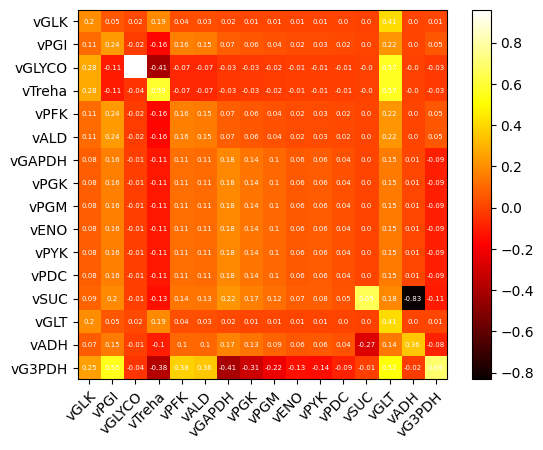

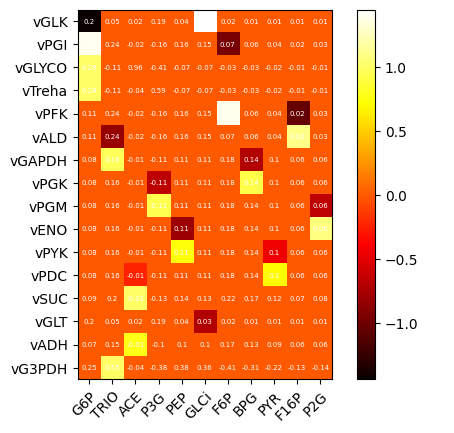

In [11]:
plot_FCC_heatmap(r)
plot_elasticity_heatmap(r)

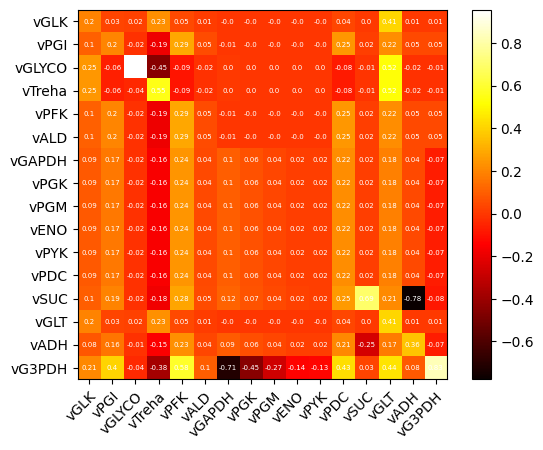

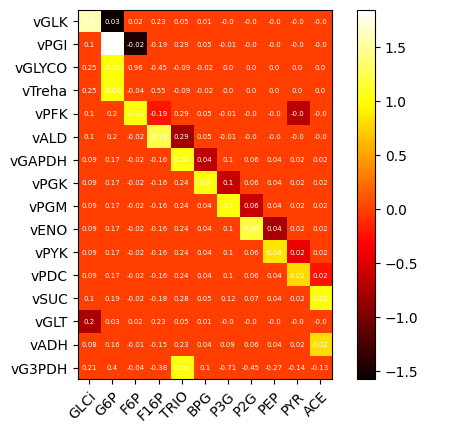

In [12]:
plot_FCC_heatmap(r1)
plot_elasticity_heatmap(r1)

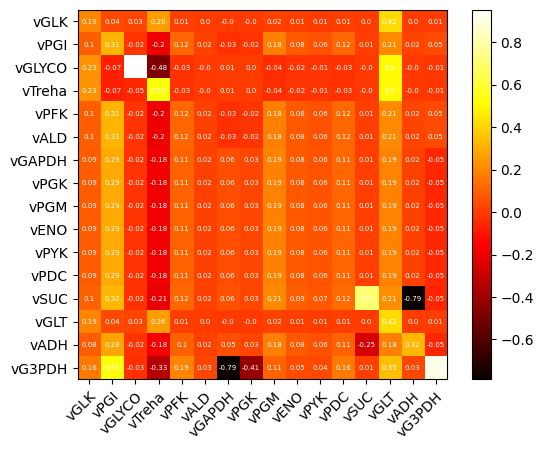

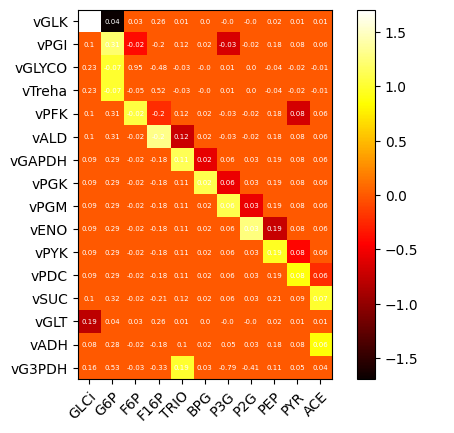

In [13]:
plot_FCC_heatmap(r2)
plot_elasticity_heatmap(r2)

In [ ]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

In [10]:
vstar = BIOMD64.v_star[:9]

In [12]:
BIOMD64.N[:, vstar < 0] = -1 * BIOMD64.N[:, vstar < 0]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 18 but corresponding boolean dimension is 9

In [13]:
BIOMD64.N.shape

(16, 18)

In [4]:
enzymes = [i for i in data.columns if 'e_' in i]

a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]
pt_enz.insert(0, 'e_vPGK')

C:\Users\user\AppData\Local\Temp\ipykernel_19144\4088482062.py:4: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [5]:
a = data[data[enzymes] != 1].values.flatten()
# a = data[enzymes].values.flatten()
pt_lvls = a[~np.isnan(a)]
pt_lvls = list(pt_lvls)
pt_lvls.insert(0, 1.0)

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [6]:
# get the real flux values
real_flux_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_flux_values = real_flux_values.div(real_flux_values.iloc[0])
# rel_real_flux_values.drop(rel_real_flux_values.index[0], inplace=True)
rel_real_flux_values.columns = r.getReactionIds()
rel_real_flux_values = rel_real_flux_values.transpose()
rel_real_flux_values.columns = enzPtLvls

In [7]:
# get the real inmet values
real_inmet_values = data[[i for i in data.columns if i in r.getFloatingSpeciesIds()]]
rel_real_inmet_values = real_inmet_values.div(real_inmet_values.iloc[0])
# rel_real_inmet_values.drop(rel_real_inmet_values.index[0], inplace=True)
rel_real_inmet_values = rel_real_inmet_values.transpose()
rel_real_inmet_values.columns = enzPtLvls
rel_real_inmet_values

,e_vPGK|1.0,e_vGLK|0.9,e_vGLK|1.1,e_vPGI|0.9,e_vPGI|1.1,e_vGLYCO|0.9,e_vGLYCO|1.1,e_vTreha|0.9,e_vTreha|1.1,e_vPFK|0.9,e_vPFK|1.1,e_vALD|0.9,e_vALD|1.1,e_vGAPDH|0.9,e_vGAPDH|1.1,e_vPGK|0.9,e_vPGK|1.1,e_vPGM|0.9,e_vPGM|1.1,e_vENO|0.9,e_vENO|1.1,e_vPYK|0.9,e_vPYK|1.1,e_vPDC|0.9,e_vPDC|1.1,e_vSUC|0.9,e_vSUC|1.1,e_vGLT|0.9,e_vGLT|1.1,e_vADH|0.9,e_vADH|1.1,e_vG3PDH|0.9,e_vG3PDH|1.1,e_vATP|0.9,e_vATP|1.1,e_vGLK|0.887,e_vGLK|1.113,e_vPGI|0.887,e_vPGI|1.113,e_vGLYCO|0.887,e_vGLYCO|1.113,e_vTreha|0.887,e_vTreha|1.113,e_vPFK|0.887,e_vPFK|1.113,e_vALD|0.887,e_vALD|1.113,e_vGAPDH|0.887,e_vGAPDH|1.113,e_vPGK|0.887,e_vPGK|1.113,e_vPGM|0.887,e_vPGM|1.113,e_vENO|0.887,e_vENO|1.113,e_vPYK|0.887,e_vPYK|1.113,e_vPDC|0.887,e_vPDC|1.113,e_vSUC|0.887,e_vSUC|1.113,e_vGLT|0.887,e_vGLT|1.113,e_vADH|0.887,e_vADH|1.113,e_vG3PDH|0.887,e_vG3PDH|1.113,e_vATP|0.887,e_vATP|1.113,e_vGLK|0.873,e_vGLK|1.127,e_vPGI|0.873,e_vPGI|1.127,e_vGLYCO|0.873,e_vGLYCO|1.127,e_vTreha|0.873,e_vTreha|1.127,e_vPFK|0.873,e_vPFK|1.127,e_vALD|0.873,e_vALD|1.127,e_vGAPDH|0.873,e_vGAPDH|1.127,e_vPGK|0.873,e_vPGK|1.127,e_vPGM|0.873,e_vPGM|1.127,e_vENO|0.873,e_vENO|1.127,e_vPYK|0.873,e_vPYK|1.127,e_vPDC|0.873,e_vPDC|1.127,e_vSUC|0.873,e_vSUC|1.127,e_vGLT|0.873,e_vGLT|1.127,e_vADH|0.873,e_vADH|1.127,e_vG3PDH|0.873,e_vG3PDH|1.127,e_vATP|0.873,e_vATP|1.127,e_vGLK|0.856,e_vGLK|1.144,e_vPGI|0.856,e_vPGI|1.144,e_vGLYCO|0.856,e_vGLYCO|1.144,e_vTreha|0.856,e_vTreha|1.144,e_vPFK|0.856,e_vPFK|1.144,e_vALD|0.856,e_vALD|1.144,e_vGAPDH|0.856,e_vGAPDH|1.144,e_vPGK|0.856,e_vPGK|1.144,e_vPGM|0.856,e_vPGM|1.144,e_vENO|0.856,e_vENO|1.144,e_vPYK|0.856,e_vPYK|1.144,e_vPDC|0.856,e_vPDC|1.144,e_vSUC|0.856,e_vSUC|1.144,e_vGLT|0.856,e_vGLT|1.144,e_vADH|0.856,e_vADH|1.144,e_vG3PDH|0.856,e_vG3PDH|1.144,e_vATP|0.856,e_vATP|1.144,e_vGLK|0.838,e_vGLK|1.162,e_vPGI|0.838,e_vPGI|1.162,e_vGLYCO|0.838,e_vGLYCO|1.162,e_vTreha|0.838,e_vTreha|1.162,e_vPFK|0.838,e_vPFK|1.162,e_vALD|0.838,e_vALD|1.162,e_vGAPDH|0.838,e_vGAPDH|1.162,e_vPGK|0.838,e_vPGK|1.162,e_vPGM|0.838,e_vPGM|1.162,e_vENO|0.838,e_vENO|1.162,e_vPYK|0.838,e_vPYK|1.162,e_vPDC|0.838,e_vPDC|1.162,e_vSUC|0.838,e_vSUC|1.162,e_vGLT|0.838,e_vGLT|1.162,e_vADH|0.838,e_vADH|1.162,e_vG3PDH|0.838,e_vG3PDH|1.162,e_vATP|0.838,e_vATP|1.162,e_vGLK|0.817,e_vGLK|1.183,e_vPGI|0.817,e_vPGI|1.183,e_vGLYCO|0.817,e_vGLYCO|1.183,e_vTreha|0.817,e_vTreha|1.183,e_vPFK|0.817,e_vPFK|1.183,e_vALD|0.817,e_vALD|1.183,e_vGAPDH|0.817,e_vGAPDH|1.183,e_vPGK|0.817,e_vPGK|1.183,e_vPGM|0.817,e_vPGM|1.183,e_vENO|0.817,e_vENO|1.183,e_vPYK|0.817,e_vPYK|1.183,e_vPDC|0.817,e_vPDC|1.183,e_vSUC|0.817,e_vSUC|1.183,e_vGLT|0.817,e_vGLT|1.183,e_vADH|0.817,e_vADH|1.183,e_vG3PDH|0.817,e_vG3PDH|1.183,e_vATP|0.817,e_vATP|1.183,e_vGLK|0.793,e_vGLK|1.207,e_vPGI|0.793,e_vPGI|1.207,e_vGLYCO|0.793,e_vGLYCO|1.207,e_vTreha|0.793,e_vTreha|1.207,e_vPFK|0.793,e_vPFK|1.207,e_vALD|0.793,e_vALD|1.207,e_vGAPDH|0.793,e_vGAPDH|1.207,e_vPGK|0.793,e_vPGK|1.207,e_vPGM|0.793,e_vPGM|1.207,e_vENO|0.793,e_vENO|1.207,e_vPYK|0.793,e_vPYK|1.207,e_vPDC|0.793,e_vPDC|1.207,e_vSUC|0.793,e_vSUC|1.207,e_vGLT|0.793,e_vGLT|1.207,e_vADH|0.793,e_vADH|1.207,e_vG3PDH|0.793,e_vG3PDH|1.207,e_vATP|0.793,e_vATP|1.207,e_vGLK|0.766,e_vGLK|1.234,e_vPGI|0.766,e_vPGI|1.234,e_vGLYCO|0.766,e_vGLYCO|1.234,e_vTreha|0.766,e_vTreha|1.234,e_vPFK|0.766,e_vPFK|1.234,e_vALD|0.766,e_vALD|1.234,e_vGAPDH|0.766,e_vGAPDH|1.234,e_vPGK|0.766,e_vPGK|1.234,e_vPGM|0.766,e_vPGM|1.234,e_vENO|0.766,e_vENO|1.234,e_vPYK|0.766,e_vPYK|1.234,e_vPDC|0.766,e_vPDC|1.234,e_vSUC|0.766,e_vSUC|1.234,e_vGLT|0.766,e_vGLT|1.234,e_vADH|0.766,e_vADH|1.234,e_vG3PDH|0.766,e_vG3PDH|1.234,e_vATP|0.766,e_vATP|1.234,e_vGLK|0.736,e_vGLK|1.264,e_vPGI|0.736,e_vPGI|1.264,e_vGLYCO|0.736,e_vGLYCO|1.264,e_vTreha|0.736,e_vTreha|1.264,e_vPFK|0.736,e_vPFK|1.264,e_vALD|0.736,e_vALD|1.264,e_vGAPDH|0.736,e_vGAPDH|1.264,e_vPGK|0.736,e_vPGK|1.264,e_vPGM|0.736,e_vPGM|1.264,e_vENO|0.736,e_vENO|1.264,e_vPYK|0.736,e_vPYK|1.264,e_vPDC|0.736,e_vPDC|1.264,e_vSUC|0.736,e_vSUC|1.264,e_vGLT|0.736,e_vGLT|1.264,e_vADH|0.736,e_v

In [8]:
# get the real exmet values
real_exmet_values = data[[i for i in data.columns if i in r.getBoundarySpeciesIds()]]
rel_real_exmet_values = real_exmet_values.div(real_exmet_values.iloc[0])
# rel_real_exmet_values.drop(rel_real_exmet_values.index[0], inplace=True)
rel_real_exmet_values = rel_real_exmet_values.transpose()
rel_real_exmet_values.columns = enzPtLvls
rel_real_exmet_values

,e_vPGK|1.0,e_vGLK|0.9,e_vGLK|1.1,e_vPGI|0.9,e_vPGI|1.1,e_vGLYCO|0.9,e_vGLYCO|1.1,e_vTreha|0.9,e_vTreha|1.1,e_vPFK|0.9,e_vPFK|1.1,e_vALD|0.9,e_vALD|1.1,e_vGAPDH|0.9,e_vGAPDH|1.1,e_vPGK|0.9,e_vPGK|1.1,e_vPGM|0.9,e_vPGM|1.1,e_vENO|0.9,e_vENO|1.1,e_vPYK|0.9,e_vPYK|1.1,e_vPDC|0.9,e_vPDC|1.1,e_vSUC|0.9,e_vSUC|1.1,e_vGLT|0.9,e_vGLT|1.1,e_vADH|0.9,e_vADH|1.1,e_vG3PDH|0.9,e_vG3PDH|1.1,e_vATP|0.9,e_vATP|1.1,e_vGLK|0.887,e_vGLK|1.113,e_vPGI|0.887,e_vPGI|1.113,e_vGLYCO|0.887,e_vGLYCO|1.113,e_vTreha|0.887,e_vTreha|1.113,e_vPFK|0.887,e_vPFK|1.113,e_vALD|0.887,e_vALD|1.113,e_vGAPDH|0.887,e_vGAPDH|1.113,e_vPGK|0.887,e_vPGK|1.113,e_vPGM|0.887,e_vPGM|1.113,e_vENO|0.887,e_vENO|1.113,e_vPYK|0.887,e_vPYK|1.113,e_vPDC|0.887,e_vPDC|1.113,e_vSUC|0.887,e_vSUC|1.113,e_vGLT|0.887,e_vGLT|1.113,e_vADH|0.887,e_vADH|1.113,e_vG3PDH|0.887,e_vG3PDH|1.113,e_vATP|0.887,e_vATP|1.113,e_vGLK|0.873,e_vGLK|1.127,e_vPGI|0.873,e_vPGI|1.127,e_vGLYCO|0.873,e_vGLYCO|1.127,e_vTreha|0.873,e_vTreha|1.127,e_vPFK|0.873,e_vPFK|1.127,e_vALD|0.873,e_vALD|1.127,e_vGAPDH|0.873,e_vGAPDH|1.127,e_vPGK|0.873,e_vPGK|1.127,e_vPGM|0.873,e_vPGM|1.127,e_vENO|0.873,e_vENO|1.127,e_vPYK|0.873,e_vPYK|1.127,e_vPDC|0.873,e_vPDC|1.127,e_vSUC|0.873,e_vSUC|1.127,e_vGLT|0.873,e_vGLT|1.127,e_vADH|0.873,e_vADH|1.127,e_vG3PDH|0.873,e_vG3PDH|1.127,e_vATP|0.873,e_vATP|1.127,e_vGLK|0.856,e_vGLK|1.144,e_vPGI|0.856,e_vPGI|1.144,e_vGLYCO|0.856,e_vGLYCO|1.144,e_vTreha|0.856,e_vTreha|1.144,e_vPFK|0.856,e_vPFK|1.144,e_vALD|0.856,e_vALD|1.144,e_vGAPDH|0.856,e_vGAPDH|1.144,e_vPGK|0.856,e_vPGK|1.144,e_vPGM|0.856,e_vPGM|1.144,e_vENO|0.856,e_vENO|1.144,e_vPYK|0.856,e_vPYK|1.144,e_vPDC|0.856,e_vPDC|1.144,e_vSUC|0.856,e_vSUC|1.144,e_vGLT|0.856,e_vGLT|1.144,e_vADH|0.856,e_vADH|1.144,e_vG3PDH|0.856,e_vG3PDH|1.144,e_vATP|0.856,e_vATP|1.144,e_vGLK|0.838,e_vGLK|1.162,e_vPGI|0.838,e_vPGI|1.162,e_vGLYCO|0.838,e_vGLYCO|1.162,e_vTreha|0.838,e_vTreha|1.162,e_vPFK|0.838,e_vPFK|1.162,e_vALD|0.838,e_vALD|1.162,e_vGAPDH|0.838,e_vGAPDH|1.162,e_vPGK|0.838,e_vPGK|1.162,e_vPGM|0.838,e_vPGM|1.162,e_vENO|0.838,e_vENO|1.162,e_vPYK|0.838,e_vPYK|1.162,e_vPDC|0.838,e_vPDC|1.162,e_vSUC|0.838,e_vSUC|1.162,e_vGLT|0.838,e_vGLT|1.162,e_vADH|0.838,e_vADH|1.162,e_vG3PDH|0.838,e_vG3PDH|1.162,e_vATP|0.838,e_vATP|1.162,e_vGLK|0.817,e_vGLK|1.183,e_vPGI|0.817,e_vPGI|1.183,e_vGLYCO|0.817,e_vGLYCO|1.183,e_vTreha|0.817,e_vTreha|1.183,e_vPFK|0.817,e_vPFK|1.183,e_vALD|0.817,e_vALD|1.183,e_vGAPDH|0.817,e_vGAPDH|1.183,e_vPGK|0.817,e_vPGK|1.183,e_vPGM|0.817,e_vPGM|1.183,e_vENO|0.817,e_vENO|1.183,e_vPYK|0.817,e_vPYK|1.183,e_vPDC|0.817,e_vPDC|1.183,e_vSUC|0.817,e_vSUC|1.183,e_vGLT|0.817,e_vGLT|1.183,e_vADH|0.817,e_vADH|1.183,e_vG3PDH|0.817,e_vG3PDH|1.183,e_vATP|0.817,e_vATP|1.183,e_vGLK|0.793,e_vGLK|1.207,e_vPGI|0.793,e_vPGI|1.207,e_vGLYCO|0.793,e_vGLYCO|1.207,e_vTreha|0.793,e_vTreha|1.207,e_vPFK|0.793,e_vPFK|1.207,e_vALD|0.793,e_vALD|1.207,e_vGAPDH|0.793,e_vGAPDH|1.207,e_vPGK|0.793,e_vPGK|1.207,e_vPGM|0.793,e_vPGM|1.207,e_vENO|0.793,e_vENO|1.207,e_vPYK|0.793,e_vPYK|1.207,e_vPDC|0.793,e_vPDC|1.207,e_vSUC|0.793,e_vSUC|1.207,e_vGLT|0.793,e_vGLT|1.207,e_vADH|0.793,e_vADH|1.207,e_vG3PDH|0.793,e_vG3PDH|1.207,e_vATP|0.793,e_vATP|1.207,e_vGLK|0.766,e_vGLK|1.234,e_vPGI|0.766,e_vPGI|1.234,e_vGLYCO|0.766,e_vGLYCO|1.234,e_vTreha|0.766,e_vTreha|1.234,e_vPFK|0.766,e_vPFK|1.234,e_vALD|0.766,e_vALD|1.234,e_vGAPDH|0.766,e_vGAPDH|1.234,e_vPGK|0.766,e_vPGK|1.234,e_vPGM|0.766,e_vPGM|1.234,e_vENO|0.766,e_vENO|1.234,e_vPYK|0.766,e_vPYK|1.234,e_vPDC|0.766,e_vPDC|1.234,e_vSUC|0.766,e_vSUC|1.234,e_vGLT|0.766,e_vGLT|1.234,e_vADH|0.766,e_vADH|1.234,e_vG3PDH|0.766,e_vG3PDH|1.234,e_vATP|0.766,e_vATP|1.234,e_vGLK|0.736,e_vGLK|1.264,e_vPGI|0.736,e_vPGI|1.264,e_vGLYCO|0.736,e_vGLYCO|1.264,e_vTreha|0.736,e_vTreha|1.264,e_vPFK|0.736,e_vPFK|1.264,e_vALD|0.736,e_vALD|1.264,e_vGAPDH|0.736,e_vGAPDH|1.264,e_vPGK|0.736,e_vPGK|1.264,e_vPGM|0.736,e_vPGM|1.264,e_vENO|0.736,e_vENO|1.264,e_vPYK|0.736,e_vPYK|1.264,e_vPDC|0.736,e_vPDC|1.264,e_vSUC|0.736,e_vSUC|1.264,e_vGLT|0.736,e_vGLT|1.264,e_vADH|0.736,e_v

In [9]:
N = BIOMD64.N
Ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))


In [10]:
pt_lvls = list(set([i.split('|')[1] for i in rel_real_flux_values.columns]))
pt_lvls.sort()

In [11]:
enzyme_perts = data[[i for i in data.columns if 'e_' in i]]
enzyme_perts = enzyme_perts.transpose()
enzyme_perts.columns = enzPtLvls
enzyme_perts.shape

(17, 642)

In [95]:
# data for graphing
x_data = data[r.getFloatingSpeciesIds()]
x_star = x_data.iloc[0].values
x_star[x_star == 0] = 1e-6
xn = x_data.divide(x_star)

y_data = data[r.getBoundarySpeciesIds()]
y_star = y_data.iloc[0].values
y_star[y_star == 0] = 1e-6
yn = y_data.divide(y_star)

vn = real_flux_values
e_hat = enzyme_perts.values.T

In [13]:
n_exp = len(data)
v_star = BIOMD64.v_star[np.newaxis,:]
product = (e_hat*v_star)

def my_func(a): 
    return np.diag(a)

c = np.apply_along_axis(my_func, 1, product)

N_rep = N.reshape((-1, *N.shape)).repeat(642, axis=0) # (642, 14, 17)

A = (N_rep@c@Ex) # (642, 14, 14)
arr = ((np.ones((len(N.T),n_exp)) + (Ey @ np.log(yn.T)))).values
arr = arr.T[:,:, np.newaxis]
b = -(N_rep@c) @ arr # (642, 14, 642)

Xss = []
for i in range(n_exp): 
    Xss.append(np.linalg.pinv(A[i])@b[i])


In [113]:
from emll.aesara_utils import LeastSquaresSolve
def mymethod(e_hat, v_star):
    n_exp = len(e_hat)
    
    v_star = v_star[np.newaxis,:]
    product = (e_hat*v_star)

    def my_func(a): 
        return np.diag(a)
    c = np.apply_along_axis(my_func, 1, product)
    
    N_rep = N.reshape((-1, *N.shape)).repeat(642, axis=0) # (642, 14, 17)
    
    As = (N_rep@c@Ex) # (642, 14, 14)
    
    arr = ((np.ones((len(N.T),n_exp)) + (Ey @ np.log(yn.T)))).values
    arr = arr.T[:,:, np.newaxis]
    bs = -(N_rep@c) @ arr # (642, 14, 642)

    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()
    
    xn, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)
    
    vn = e_hat * (np.ones((17, 642)) +
                   at.dot(Ex, xn.T) +
                   at.dot(Ey, yn.T)).T

    return xn, vn

In [114]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [115]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=e_hat)
    y_obs = pm.Normal('y_obs', mu=1, sigma=10, observed=yn)


In [116]:
with pymc_model:
    
    # likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    xn_ss, vn_ss = mymethod(e_hat, BIOMD64.v_star)
    chi_obs = pm.Normal('chi_obs', mu=xn_ss, sigma=1, observed=xn)
    v_hat_obs = pm.Normal('v_hat_obs', mu=vn_ss, sigma=1, observed=vn)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [117]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.7471e+15
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


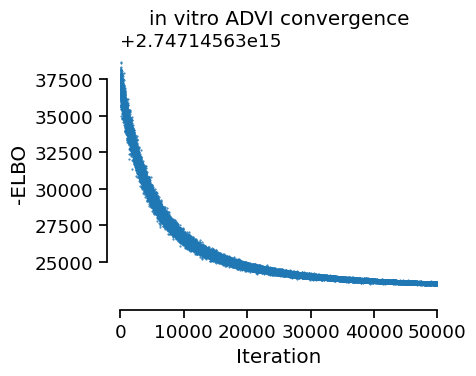

In [118]:
import seaborn as sns
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4))
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    # plt.ylim([-1E1, 1E3])
    plt.xlim([0, 50000])
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('in vitro ADVI convergence')
    plt.tight_layout()
    # plt.savefig('wu_elbo.svg', transparent=True, dpi=200)